# Function Generator

             x      f(x)
0     0.000000  5.406708
1     0.050251  5.378221
2     0.100503  5.350722
3     0.150754  5.324207
4     0.201005  5.298675
..         ...       ...
195   9.798995  5.817120
196   9.849246  5.841158
197   9.899497  5.864967
198   9.949749  5.888502
199  10.000000  5.911716

[200 rows x 2 columns]


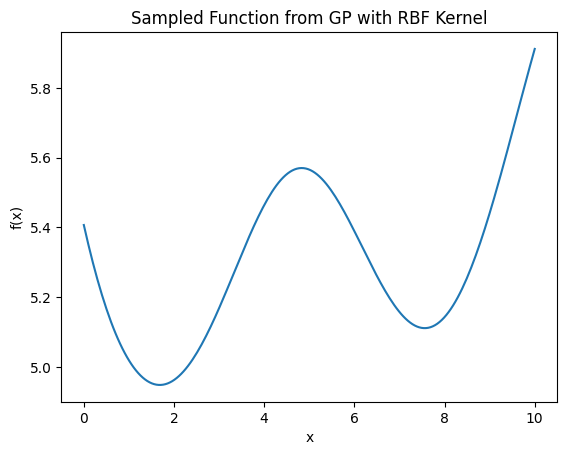

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rbf_kernel_mult(X1, X2, length_scale=0.4, variance=2.0):
    sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return variance * np.exp(-0.5 / length_scale**2 * sqdist)

# Define parameters
length_scale = 2.5
  # Length scale of the RBF kernel
variance = 1      # Variance of the RBF kernel
n_points = 200      # Number of points to sample
x = np.linspace(0, 10, n_points).reshape(-1, 1)  # Input points

# Compute the covariance matrix using the RBF kernel
cov_matrix = rbf_kernel_mult(x, x, length_scale, variance)

# Sample a function from the GP
mean = np.zeros(n_points) + 5
sampled_function = np.random.multivariate_normal(mean, cov_matrix)

df = pd.DataFrame({'x': x.flatten(), 'f(x)': sampled_function})
print(df)

# Plot the sampled function
import matplotlib.pyplot as plt
plt.plot(x, sampled_function)
plt.title("Sampled Function from GP with RBF Kernel")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [55]:
# Save the sampled function to a csv file
name = input("Enter a name for the sampled function: ")
lower_x = float(input("Enter the lower bound for the sampled function: "))
upper_x = float(input("Enter the upper bound for the sampled function: "))

evaluated_function = df[(df['x'] >= lower_x) & (df['x'] <= upper_x)]

# Reset x values to start from 0
evaluated_function['x'] = evaluated_function['x'] - lower_x

np.savetxt(f"test_functions/sampled_function_{name}.csv", evaluated_function, delimiter=",")

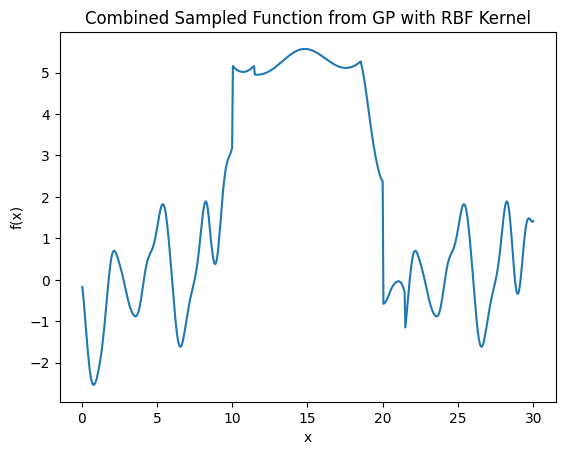

In [ ]:
def combine_sampled_functions(filenames):
    combined_df = pd.DataFrame()
    for filename in filenames:
        df = pd.read_csv(filename, names=['x', 'f(x)'], header=0)
        if combined_df.empty:
            combined_df = df
        else:
            last_x = combined_df['x'].iloc[-1]
            df['x'] += last_x
            combined_df = pd.concat([combined_df, df], ignore_index=True)

            # Smooth the combined function at transition point with a continuous interpolation
            interpolation_range = 1.5
            transition_start = last_x - interpolation_range
            transition_end = last_x + interpolation_range
            transition_mask = (combined_df['x'] >= transition_start) & (combined_df['x'] <= transition_end)
            transition_x = combined_df['x'][transition_mask]
            
            # Create a smooth transition using a weighted average
            weights = np.linspace(0, 1, len(transition_x))
            transition_y = (1 - weights) * combined_df['f(x)'][transition_mask].values + weights * df['f(x)'].iloc[:len(transition_x)].values
            
            combined_df.loc[transition_mask, 'f(x)'] = transition_y

    return combined_df


filenames = ['test_functions/sampled_function_l0_5_v1.csv', 'test_functions/sampled_function_l2_5_v1.csv', 'test_functions/sampled_function_l0_5_v1.csv']
combined_df = combine_sampled_functions(filenames)

# Plot the combined sampled function
plt.plot(combined_df['x'], combined_df['f(x)'])
plt.title("Combined Sampled Function from GP with RBF Kernel")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

# Save funtion to a csv file
name = input("Enter a name for the combined sampled function: ")
np.savetxt(f"test_functions/result_function_{name}.csv", combined_df, delimiter=",")


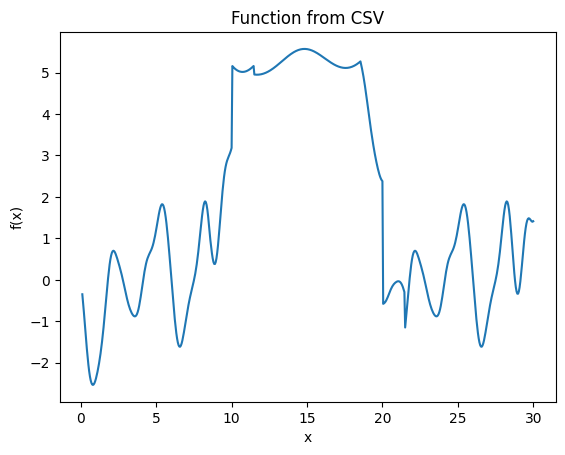

In [ ]:
# Plot function from csv file
def plot_function_from_csv(filename):
    df = pd.read_csv(filename, names=['x', 'f(x)'], header=0)
    plt.plot(df['x'], df['f(x)'])
    plt.title("Function from CSV")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.show()

filename = 'test_functions/result_function_2.csv'
plot_function_from_csv(filename)


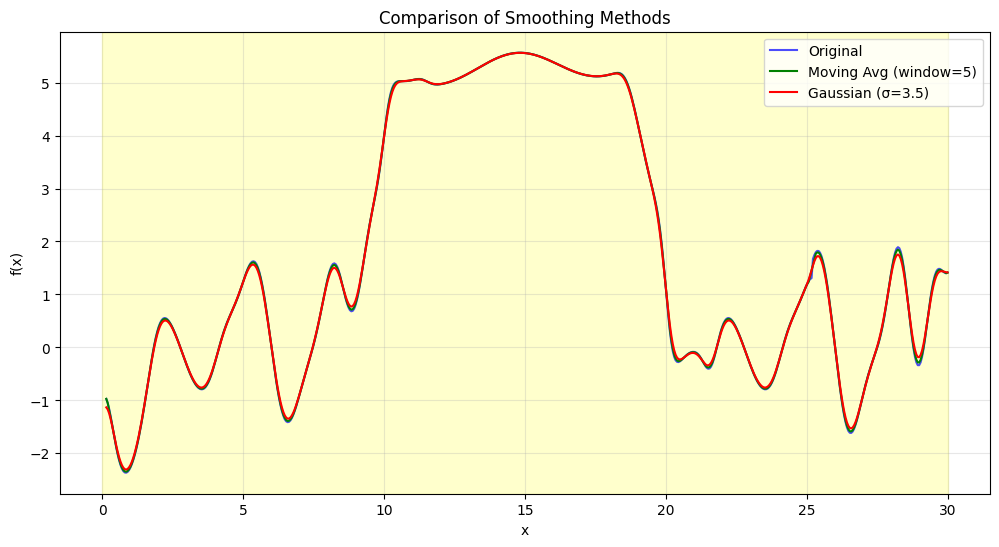

In [ ]:
# Extra smoothing in specified intervals with multiple smoothing methods
from scipy.ndimage import gaussian_filter1d

def smooth_function(df, intervals, method='moving_average', window_size=1, sigma=1.0):

    df_copy = df.copy()
    
    for start, end in intervals:
        mask = (df_copy['x'] >= start) & (df_copy['x'] <= end)
        
        if method == 'moving_average':
            # Original moving average method
            transition_y = df_copy['f(x)'][mask].rolling(window=window_size, center=True).mean()
            # Fill NaN values at the edges with original values
            transition_y = transition_y.fillna(df_copy['f(x)'][mask])
            
        elif method == 'gaussian':
            # Gaussian smoothing method
            y_values = df_copy.loc[mask, 'f(x)'].values
            transition_y = gaussian_filter1d(y_values, sigma=sigma)
        
        else:
            raise ValueError(f"Unknown smoothing method: {method}. Use 'moving_average' or 'gaussian'.")
        
        df_copy.loc[mask, 'f(x)'] = transition_y

    return df_copy

intervals = [(0, 30)] #[(5.5, 10.7), (14.0, 18)]
df = pd.read_csv('test_functions/smoothed_function_2.csv', names=['x', 'f(x)'], header=0)

# Create plot to compare smoothing methods
plt.figure(figsize=(12, 6))
plt.plot(df['x'], df['f(x)'], 'b-', label='Original', alpha=0.7)

# Apply moving average smoothing (original method)
ma_smoothed = smooth_function(df, intervals, method='moving_average', window_size=5)
plt.plot(ma_smoothed['x'], ma_smoothed['f(x)'], 'g-', label='Moving Avg (window=5)')

# Apply Gaussian smoothing
gaussian_smoothed = smooth_function(df, intervals, method='gaussian', sigma=2.5)
plt.plot(gaussian_smoothed['x'], gaussian_smoothed['f(x)'], 'r-', label='Gaussian (σ=3.5)')

# Highlight the smoothed intervals
for start, end in intervals:
    plt.axvspan(start, end, color='yellow', alpha=0.2)

plt.title("Comparison of Smoothing Methods")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Choose smoothing method and parameters
method = input("Choose smoothing method (moving_average/gaussian): ")

if method == 'moving_average':
    window_size = int(input("Enter window size for moving average: "))
    smoothed_df = smooth_function(df, intervals, method=method, window_size=window_size)
elif method == 'gaussian':
    sigma = float(input("Enter sigma value for Gaussian smoothing: "))
    smoothed_df = smooth_function(df, intervals, method=method, sigma=sigma)

# Save the smoothed function to a csv file
name = input("Enter a name for the smoothed function: ")
np.savetxt(f"test_functions/smoothed_function_{name}.csv", smoothed_df, delimiter=",")

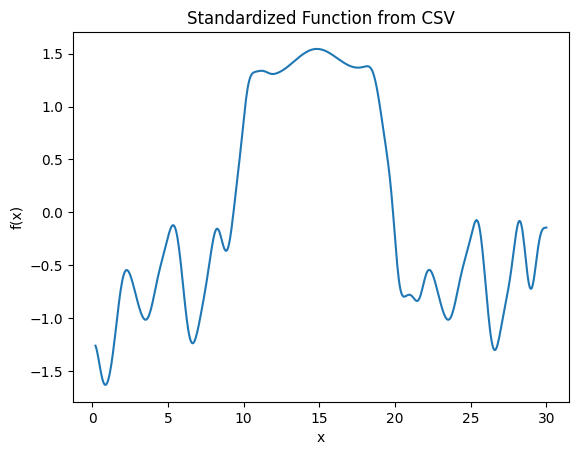

In [ ]:
# Standardize the function
def standardize_function(df):
    mean = df['f(x)'].mean()
    std = df['f(x)'].std()
    df['f(x)'] = (df['f(x)'] - mean) / std
    return df

df = pd.read_csv('test_functions/smoothed_function_2.csv', names=['x', 'f(x)'], header=0)
standardized_df = standardize_function(df)

# Plot the standardized function
plt.plot(standardized_df['x'], standardized_df['f(x)'])
plt.title("Standardized Function from CSV")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()
# Save the standardized function to a csv file
name = input("Enter a name for the standardized function: ")
np.savetxt(f"test_functions/standardized_function_{name}.csv", standardized_df, delimiter=",")